# 1 Import Packages

In [1]:
import xarray as xr
import numpy as np
import os

import src.config as config
import src.utils as utils

import pandas as pd
from tqdm import tqdm

import innvestigate
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import tensorflow as tf
tf.compat.v1.disable_eager_execution()


2023-02-20 10:32:00.736206: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2 Metadata

In [2]:
lev_index = 23
exp_index = 0
exp_name = "cv"

In [3]:
ml_transform_path = os.path.join(config.data_pro_path,"ml_transform", exp_name)

In [4]:
train_data_amoc_depth_1020_lat_26_samplestd  = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplestd.nc" ))["atlantic_moc"]
train_data_amoc_depth_1020_lat_26_samplemean = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplemean,nc"))["atlantic_moc"]

In [5]:
train_x_filename = "train_data_stack_lonlatstandardized_lev_{}_{}.nc".format(lev_index, exp_index)
valid_x_filename = "valid_data_stack_lonlatstandardized_lev_{}_{}.nc".format(lev_index, exp_index)

train_y_filename = "train_data_amoc_depth_1020_lat_26_samplestandardized_{}_{}.nc".format(lev_index, exp_index)
valid_y_filename = "valid_data_amoc_depth_1020_lat_26_samplestandardized_{}_{}.nc".format(lev_index, exp_index)

# 3 Load Data

In [6]:
train_x_xr = xr.open_dataset(os.path.join(ml_transform_path, train_x_filename))
valid_x_xr = xr.open_dataset(os.path.join(ml_transform_path, valid_x_filename))

In [7]:
train_y_xr = xr.open_dataset(os.path.join(ml_transform_path, train_y_filename))
valid_y_xr = xr.open_dataset(os.path.join(ml_transform_path, valid_y_filename))

In [8]:
train_data_amoc_depth_1020_lat_26_samplestd  = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplestd.nc" ))
train_data_amoc_depth_1020_lat_26_samplemean = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplemean,nc"))

# 4 Processing

In [9]:
train_x_xr_stack = train_x_xr.stack(sample=("realization","time"))
valid_x_xr_stack = valid_x_xr.stack(sample=("realization","time"))

In [10]:
train_y_xr_stack = train_y_xr.stack(sample=("realization","time"))
valid_y_xr_stack = valid_y_xr.stack(sample=("realization","time"))


In [11]:
valid_sample_coords = valid_y_xr_stack.sample
train_sample_coords = train_y_xr_stack.sample

train_x_ml_np = np.nan_to_num(np.expand_dims(train_x_xr_stack["rho"].transpose("sample",...).values,3),0)
valid_x_ml_np = np.nan_to_num(np.expand_dims(valid_x_xr_stack["rho"].transpose("sample",...).values,3),0)

train_y_ml_np = train_y_xr_stack["atlantic_moc"].values
valid_y_ml_np = valid_y_xr_stack["atlantic_moc"].values

In [12]:
train_data_amoc_depth_1020_lat_26_samplestd  = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplestd.nc" ))
train_data_amoc_depth_1020_lat_26_samplemean = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplemean,nc"))

In [13]:
lon = train_x_xr_stack.lon
lat = train_x_xr_stack.lat

# 5 Analyze

In [14]:
ml_exp_id =1

In [15]:
model_name = "conv_level_{}_experiment_{}".format(lev_index, ml_exp_id)
model_path = os.path.join(config.model_path,exp_name, model_name)

In [16]:
model_plot_path = os.path.join(model_path, "plots")
os.makedirs(model_plot_path, exist_ok=True)

## 5.1 History

In [43]:
csv_file = os.path.join(model_path, "history.csv")
history = pd.read_csv(csv_file)

In [44]:
min_epoch_diff = np.abs(history).idxmin(axis=0)["diff_mse_epoch_end"]
min_epoch_valid = history.idxmin(axis=0)["valid_mse_epoch_end"]
min_epoch_train = history.idxmin(axis=0)["train_mse_epoch_end"]

Text(112.59722222222221, 0.5, 'mse')

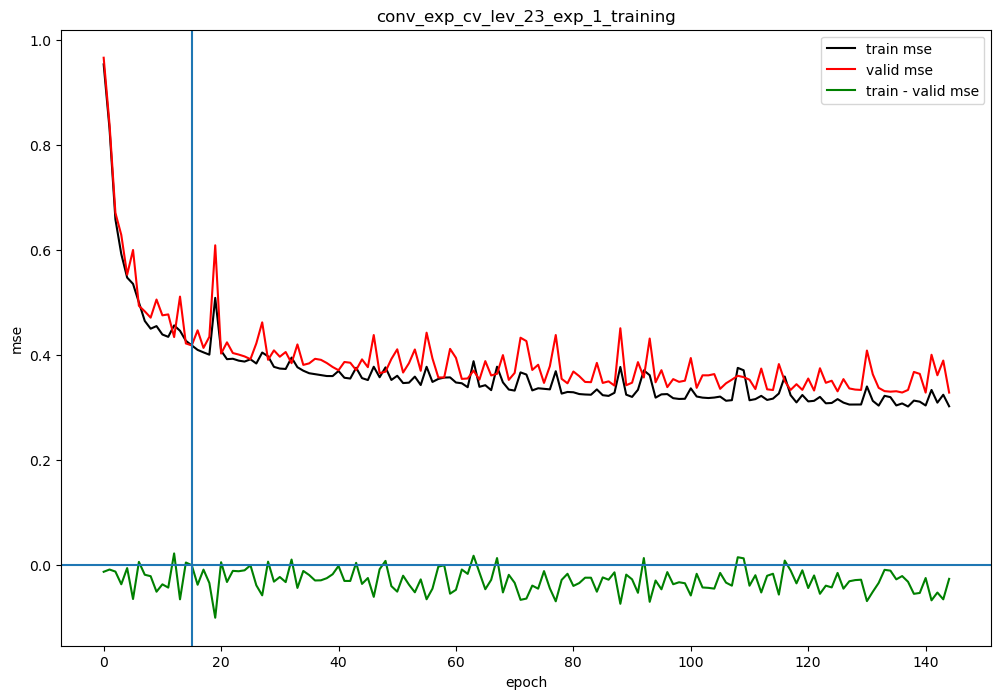

In [45]:
plt.figure(figsize=(12,8))



plt.plot(history["epoch"], history["train_mse_epoch_end"], color="black", label="train mse")
plt.plot(history["epoch"], history["valid_mse_epoch_end"], color="red", label="valid mse")
plt.plot(history["epoch"], history["diff_mse_epoch_end"], color="green", label="train - valid mse")


plt.axvline(min_epoch_diff)



name = "conv_exp_{}_lev_{}_exp_{}_training".format(exp_name, lev_index, ml_exp_id )
plt.title(name)
plt.savefig(os.path.join(model_plot_path, name))


plt.axhline(0)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("mse")


# Analyze Best Model

In [46]:
model_file_template = os.path.join(model_path, "saved-model-{epoch:02d}.hdf5")


In [47]:
min_epoch_diff

15

In [22]:
# I need to add one to the minimum epoch since in the csv files the epochs start at zero
best_model_weights_file = model_file_template.format(epoch=min_epoch_diff+1)

In [23]:
model = tf.keras.models.load_model(best_model_weights_file)

2023-02-20 10:33:54.727358: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 10:33:54.759920: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-02-20 10:33:54.771131: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


## Prediction

In [24]:
y_train_pred = model.predict(train_x_ml_np)
y_train_true = train_y_ml_np

y_valid_pred = model.predict(valid_x_ml_np)
y_valid_true = valid_y_ml_np

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [27]:
y_train_pred_xr = xr.DataArray(y_train_pred[:,0], name = "train_pred", dims = ["sample"], coords = {"sample": train_sample_coords}).unstack()
y_valid_pred_xr = xr.DataArray(y_valid_pred[:,0], name = "valid_pred", dims = ["sample"], coords = {"sample": valid_sample_coords}).unstack()

In [28]:
y_train_true_xr = train_y_xr["atlantic_moc"].rename("train_true")
y_valid_true_xr = valid_y_xr["atlantic_moc"].rename("train_true")

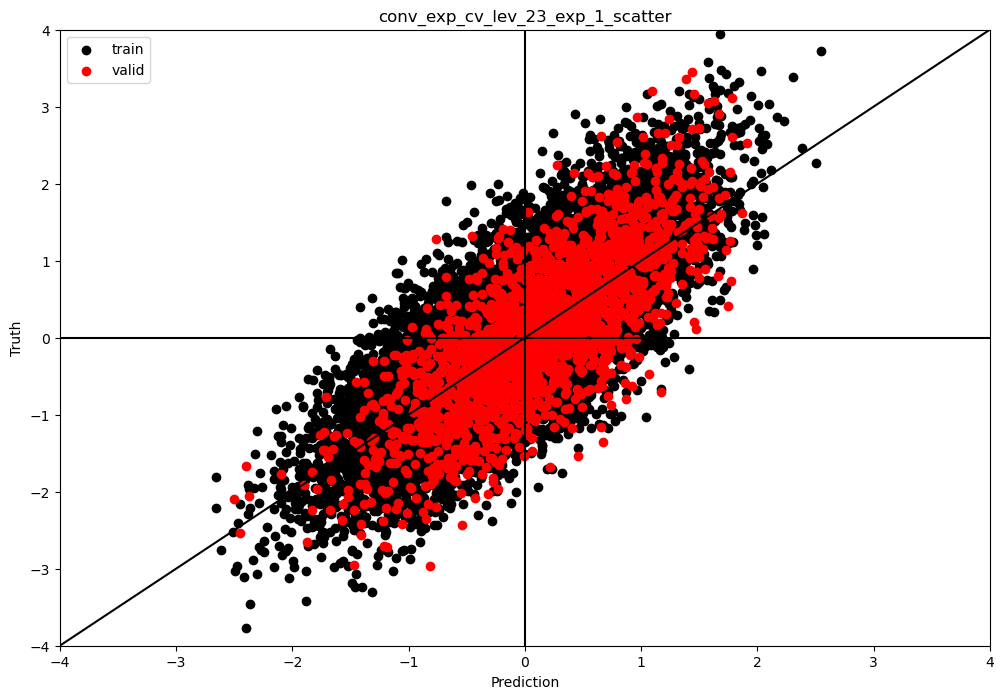

In [31]:
plt.figure(figsize=(12,8))

plt.scatter(y_train_pred, y_train_true, label="train", color="black")
plt.scatter(y_valid_pred, y_valid_true, label="valid", color="red")


x = np.arange(-4,4+1)

plt.plot(x,x, color="black")
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.axhline(0, color="black")
plt.axvline(0, color="black")

plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.legend()


name = "conv_exp_{}_lev_{}_exp_{}_scatter".format(exp_name, lev_index, ml_exp_id )
plt.title(name)
plt.savefig(os.path.join(model_plot_path, name))



In [372]:
y_train_pred_rescaled_xr = y_train_pred_xr*train_data_amoc_depth_1020_lat_26_samplestd + train_data_amoc_depth_1020_lat_26_samplemean
y_train_true_rescaled_xr = y_train_true_xr*train_data_amoc_depth_1020_lat_26_samplestd + train_data_amoc_depth_1020_lat_26_samplemean
y_valid_pred_rescaled_xr = y_valid_pred_xr*train_data_amoc_depth_1020_lat_26_samplestd + train_data_amoc_depth_1020_lat_26_samplemean
y_valid_true_rescaled_xr = y_valid_true_xr*train_data_amoc_depth_1020_lat_26_samplestd + train_data_amoc_depth_1020_lat_26_samplemean

(0.0, 100.0)

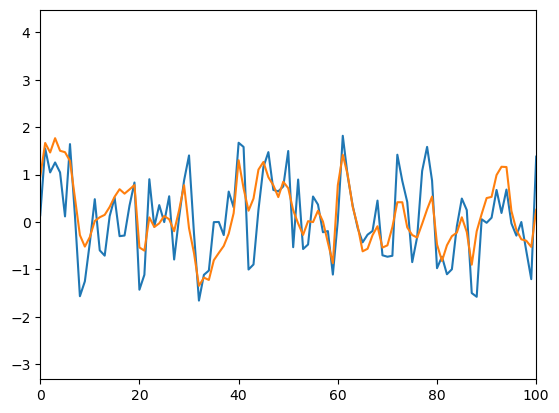

In [32]:
plt.plot(y_valid_true)
plt.plot(y_valid_pred)

plt.xlim(0,100)

(0.0, 100.0)

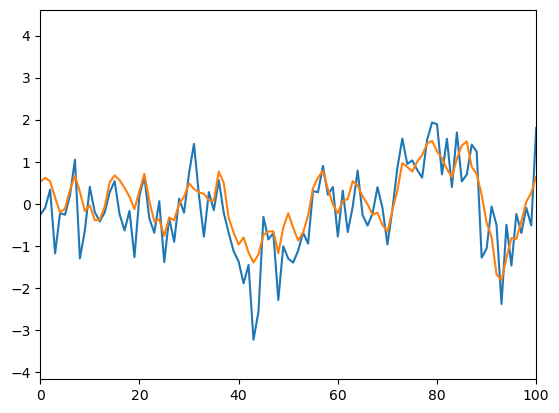

In [33]:
plt.plot(y_train_true)
plt.plot(y_train_pred)

plt.xlim(0,100)

# LRP

In [40]:
analyzer_list = ["lrp.epsilon", "lrp.z", "lrp_alpha_2_beta_1"]

In [41]:
innvestigate.create_analyzer("lrp.z",model)

In [42]:
analyzer = innvestigate.create_analyzer("lrp.z", model)
heatmaps = analyzer.analyze(train_x_ml_np[:,:,:,:])
heatmaps_xr = xr.DataArray(np.squeeze(heatmaps), name="heatmap", dims = ["sample", "lat","lon"], coords = {"sample":train_sample_coords, "lon":lon,"lat":lat})

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


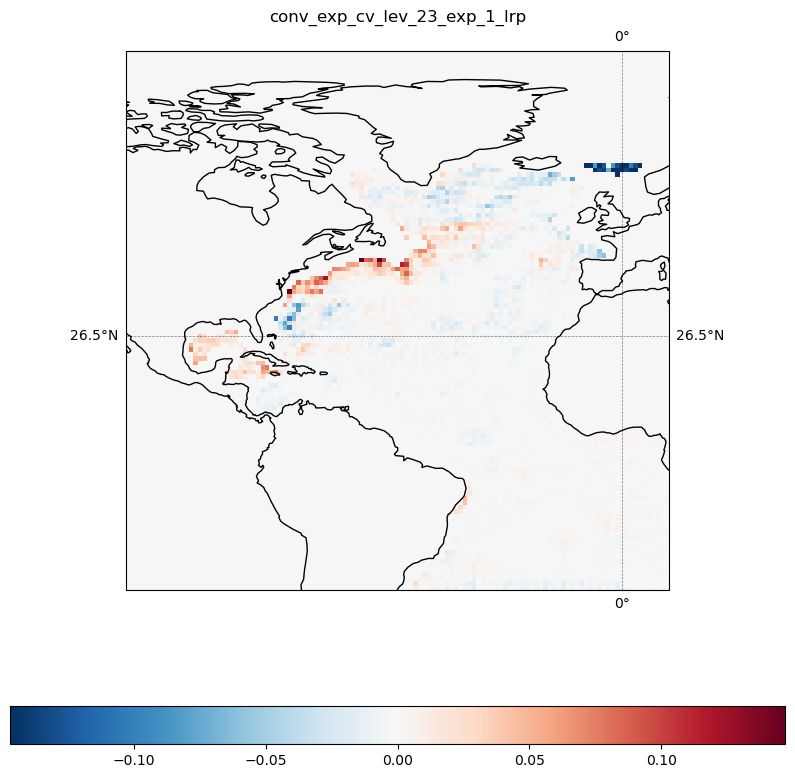

In [39]:
fig, ax = plt.subplots(1,1, figsize=(10,10), subplot_kw={"projection":ccrs.PlateCarree()})

tmp = heatmaps_xr.isel(sample=345)
vmax = np.abs(tmp).quantile(0.999)


plot = ax.pcolormesh(lon, lat, tmp.transpose("lat","lon"), vmin=-vmax, vmax=vmax, transform=ccrs.PlateCarree(),cmap="RdBu_r")
ax.gridlines(xlocs=[0], ylocs = [26.5], draw_labels=True, linewidth=0.5, color='k', alpha=0.5, linestyle='--')

plt.colorbar(plot, ax = ax, orientation="horizontal")
ax.coastlines()

name = "conv_exp_{}_lev_{}_exp_{}_lrp".format(exp_name, lev_index, ml_exp_id )
plt.title(name)
plt.savefig(os.path.join(model_plot_path, name))



